In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from datetime import datetime, timedelta
from scipy import stats

import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
from matplotlib.pyplot import figure 
import matplotlib.colors as mcolors


%matplotlib inline
matplotlib.rcParams ['figure.figsize'] = (12,8)

In [2]:
import sqlite3
conn = sqlite3.connect('production.db') 
c=conn.cursor()

In [3]:
cleaned_data = pd.read_sql_query("SELECT * from cleaned_data", conn) #I am going to carry out my analysis using pandas

In [4]:
cleaned_data

,date_Hour,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,date,weekday,week_number,hour,month
0,01.01.2020 00:00 - 01.01.2020 01:00 (CET),432.0,41.0,198.0,4.0,0.0,72.0,119.0,255.0,2020-01-01 00:00:00,Wednesday,1,1,January
1,01.01.2020 01:00 - 01.01.2020 02:00 (CET),460.0,41.0,187.0,4.0,0.0,73.0,105.0,219.0,2020-01-01 00:00:00,Wednesday,1,2,January
2,01.01.2020 02:00 - 01.01.2020 03:00 (CET),413.0,34.0,184.0,4.0,0.0,72.0,96.0,226.0,2020-01-01 00:00:00,Wednesday,1,3,January
3,01.01.2020 03:00 - 01.01.2020 04:00 (CET),411.0,32.0,180.0,4.0,0.0,73.0,114.0,239.0,2020-01-01 00:00:00,Wednesday,1,4,January
4,01.01.2020 04:00 - 01.01.2020 05:00 (CET),458.0,32.0,184.0,8.0,0.0,70.0,137.0,254.0,2020-01-01 00:00:00,Wednesday,1,5,January
5,01.01.2020 05:00 - 01.01.2020 06:00 (CET),409.0,32.0,186.0,12.0,0.0,64.0,144.0,302.0,2020-01-01 00:00:00,Wednesday,1,6,January
6,01.01.2020 06:00 - 01.01.2020 07:00 (CET),410.0,32.0,185.0,12.0,0.0,63.0,168.0,329.0,2020-01-01 00:00:00,Wednesday,1,7,January
7,01.01.2020 07:00 - 01.01.2020 08:00 (CET),460.0,33.0,188.0,12.0,0.0,64.0,168.0,346.0,2020-01-01 00:00:00,Wednesday,1,8,January
8,01.01.2020 08:00 - 01.01.2020 09:00 (CET),479.0,34.0,187.0,12.0,0.0,64.0,149.0,309.0,2020-01-01 00:00:00,Wednesday,1,9,January
9,01.01.2020 09:00 - 01.01.2020 10:00 (CET),456.0,34.0,165.0,13.0,6.0,65.0,130.0,316.0,2020-01-01 00:00:00,Wednesday,1,10,January


# Analysis to answer the client's following question:
#### How much and why does the carbon footprint of electricity in Denmark change throughout the day?
Based on the hourly record, a 'time of day'  attribute is created; this is divided into Morning,Afternoon,Evening and Night. This is to understand how the carbon intensity is changing througout the day.

In [5]:
def time_of_day_func(hour):  
    if((hour>= 5) and (hour < 11)):
        return 'Morning'
    elif((hour>= 11) and (hour < 17)):
        return 'Afternoon'
    elif((hour>= 17) and (hour < 23)):
        return 'Evening'
    elif((hour==23) or (hour==24) or (hour<5)):
        return 'Night'

In [6]:
cleaned_data['time_of_day'] = cleaned_data['hour'].apply(time_of_day_func)
cleaned_data

,date_Hour,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,date,weekday,week_number,hour,month,time_of_day
0,01.01.2020 00:00 - 01.01.2020 01:00 (CET),432.0,41.0,198.0,4.0,0.0,72.0,119.0,255.0,2020-01-01 00:00:00,Wednesday,1,1,January,Night
1,01.01.2020 01:00 - 01.01.2020 02:00 (CET),460.0,41.0,187.0,4.0,0.0,73.0,105.0,219.0,2020-01-01 00:00:00,Wednesday,1,2,January,Night
2,01.01.2020 02:00 - 01.01.2020 03:00 (CET),413.0,34.0,184.0,4.0,0.0,72.0,96.0,226.0,2020-01-01 00:00:00,Wednesday,1,3,January,Night
3,01.01.2020 03:00 - 01.01.2020 04:00 (CET),411.0,32.0,180.0,4.0,0.0,73.0,114.0,239.0,2020-01-01 00:00:00,Wednesday,1,4,January,Night
4,01.01.2020 04:00 - 01.01.2020 05:00 (CET),458.0,32.0,184.0,8.0,0.0,70.0,137.0,254.0,2020-01-01 00:00:00,Wednesday,1,5,January,Morning
5,01.01.2020 05:00 - 01.01.2020 06:00 (CET),409.0,32.0,186.0,12.0,0.0,64.0,144.0,302.0,2020-01-01 00:00:00,Wednesday,1,6,January,Morning
6,01.01.2020 06:00 - 01.01.2020 07:00 (CET),410.0,32.0,185.0,12.0,0.0,63.0,168.0,329.0,2020-01-01 00:00:00,Wednesday,1,7,January,Morning
7,01.01.2020 07:00 - 01.01.2020 08:00 (CET),460.0,33.0,188.0,12.0,0.0,64.0,168.0,346.0,2020-01-01 00:00:00,Wednesday,1,8,January,Morning
8,01.01.2020 08:00 - 01.01.2020 09:00 (CET),479.0,34.0,187.0,12.0,0.0,64.0,149.0,309.0,2020-01-01 00:00:00,Wednesday,1,9,January,Morning
9,01.01.2020 09:00 - 01.01.2020 10:00 (CET),456.0,34.0,165.0,13.0,6.0,65.0,130.0,316.0,2020-01-01 00:00:00,Wednesday,1,10,January,Morning


In [7]:
cleaned_data.dtypes

date_Hour            object
biomass             float64
fossil_gas          float64
fossil_hard_coal    float64
fossil_oil          float64
solar               float64
waste               float64
wind_offshore       float64
wind_onshore        float64
date                 object
weekday              object
week_number           int64
hour                  int64
month                object
time_of_day          object
dtype: object

In [8]:
#conversion variable
to_tonne=0.001
to_kilowatt=1000

In [9]:
#carbon_intensity values in Kg
#c=carbon
biomass_c=0.23
fossil_gas_c=0.49
fossil_hard_coal_c=0.82
fossil_oil_c=0.65
solar_c=0.045
waste_c=0.7
wind_c=0.011


In [10]:
#Finding carbon intensity of each production type
#ci=carbon intensity
cleaned_data['biomass_ci']= cleaned_data['biomass']*to_kilowatt*biomass_c*to_tonne
cleaned_data['fossil_gas_ci']= cleaned_data['fossil_gas']*to_kilowatt*fossil_gas_c*to_tonne
cleaned_data['fossil_hard_coal_ci']= cleaned_data['fossil_hard_coal']*to_kilowatt*fossil_hard_coal_c*to_tonne
cleaned_data['fossil_oil_ci']= cleaned_data['fossil_oil']*to_kilowatt*fossil_oil_c*to_tonne
cleaned_data['solar_ci']= cleaned_data['solar']*to_kilowatt*solar_c*to_tonne
cleaned_data['waste_ci']= cleaned_data['waste']*to_kilowatt*waste_c*to_tonne
cleaned_data['wind_ci']= ((cleaned_data['wind_offshore'])+(cleaned_data['wind_onshore']))*to_kilowatt*wind_c*to_tonne


In [11]:
cleaned_data 

,date_Hour,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,date,...,hour,month,time_of_day,biomass_ci,fossil_gas_ci,fossil_hard_coal_ci,fossil_oil_ci,solar_ci,waste_ci,wind_ci
0,01.01.2020 00:00 - 01.01.2020 01:00 (CET),432.0,41.0,198.0,4.0,0.0,72.0,119.0,255.0,2020-01-01 00:00:00,...,1,January,Night,99.36,20.09,162.36,2.60,0.000,50.4,4.114
1,01.01.2020 01:00 - 01.01.2020 02:00 (CET),460.0,41.0,187.0,4.0,0.0,73.0,105.0,219.0,2020-01-01 00:00:00,...,2,January,Night,105.80,20.09,153.34,2.60,0.000,51.1,3.564
2,01.01.2020 02:00 - 01.01.2020 03:00 (CET),413.0,34.0,184.0,4.0,0.0,72.0,96.0,226.0,2020-01-01 00:00:00,...,3,January,Night,94.99,16.66,150.88,2.60,0.000,50.4,3.542
3,01.01.2020 03:00 - 01.01.2020 04:00 (CET),411.0,32.0,180.0,4.0,0.0,73.0,114.0,239.0,2020-01-01 00:00:00,...,4,January,Night,94.53,15.68,147.60,2.60,0.000,51.1,3.883
4,01.01.2020 04:00 - 01.01.2020 05:00 (CET),458.0,32.0,184.0,8.0,0.0,70.0,137.0,254.0,2020-01-01 00:00:00,...,5,January,Morning,105.34,15.68,150.88,5.20,0.000,49.0,4.301
5,01.01.2020 05:00 - 01.01.2020 06:00 (CET),409.0,32.0,186.0,12.0,0.0,64.0,144.0,302.0,2020-01-01 00:00:00,...,6,January,Morning,94.07,15.68,152.52,7.80,0.000,44.8,4.906
6,01.01.2020 06:00 - 01.01.2020 07:00 (CET),410.0,32.0,185.0,12.0,0.0,63.0,168.0,329.0,2020-01-01 00:00:00,...,7,January,Morning,94.30,15.68,151.70,7.80,0.000,44.1,5.467
7,01.01.2020 07:00 - 01.01.2020 08:00 (CET),460.0,33.0,188.0,12.0,0.0,64.0,168.0,346.0,2020-01-01 00:00:00,...,8,January,Morning,105.80,16.17,154.16,7.80,0.000,44.8,5.654
8,01.01.2020 08:00 - 01.01.2020 09:00 (CET),479.0,34.0,187.0,12.0,0.0,64.0,149.0,309.0,2020-01-01 00:00:00,...,9,January,Morning,110.17,16.66,153.34,7.80,0.000,44.8,5.038
9,01.01.2020 09:00 - 01.01.2020 10:00 (CET),456.0,34.0,165.0,13.0,6.0,65.0,130.0,316.0,2020-01-01 00:00:00,...,10,January,Morning,104.88,16.66,135.30,8.45,0.270,45.5,4.906


In [12]:
#total carbon intensity
cleaned_data['total_ci'] = cleaned_data['biomass_ci']+cleaned_data['fossil_gas_ci']+cleaned_data['fossil_hard_coal_ci']+cleaned_data['fossil_oil_ci']+cleaned_data['solar_ci']+cleaned_data['waste_ci']+cleaned_data['wind_ci']
cleaned_data

,date_Hour,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,date,...,month,time_of_day,biomass_ci,fossil_gas_ci,fossil_hard_coal_ci,fossil_oil_ci,solar_ci,waste_ci,wind_ci,total_ci
0,01.01.2020 00:00 - 01.01.2020 01:00 (CET),432.0,41.0,198.0,4.0,0.0,72.0,119.0,255.0,2020-01-01 00:00:00,...,January,Night,99.36,20.09,162.36,2.60,0.000,50.4,4.114,338.924
1,01.01.2020 01:00 - 01.01.2020 02:00 (CET),460.0,41.0,187.0,4.0,0.0,73.0,105.0,219.0,2020-01-01 00:00:00,...,January,Night,105.80,20.09,153.34,2.60,0.000,51.1,3.564,336.494
2,01.01.2020 02:00 - 01.01.2020 03:00 (CET),413.0,34.0,184.0,4.0,0.0,72.0,96.0,226.0,2020-01-01 00:00:00,...,January,Night,94.99,16.66,150.88,2.60,0.000,50.4,3.542,319.072
3,01.01.2020 03:00 - 01.01.2020 04:00 (CET),411.0,32.0,180.0,4.0,0.0,73.0,114.0,239.0,2020-01-01 00:00:00,...,January,Night,94.53,15.68,147.60,2.60,0.000,51.1,3.883,315.393
4,01.01.2020 04:00 - 01.01.2020 05:00 (CET),458.0,32.0,184.0,8.0,0.0,70.0,137.0,254.0,2020-01-01 00:00:00,...,January,Morning,105.34,15.68,150.88,5.20,0.000,49.0,4.301,330.401
5,01.01.2020 05:00 - 01.01.2020 06:00 (CET),409.0,32.0,186.0,12.0,0.0,64.0,144.0,302.0,2020-01-01 00:00:00,...,January,Morning,94.07,15.68,152.52,7.80,0.000,44.8,4.906,319.776
6,01.01.2020 06:00 - 01.01.2020 07:00 (CET),410.0,32.0,185.0,12.0,0.0,63.0,168.0,329.0,2020-01-01 00:00:00,...,January,Morning,94.30,15.68,151.70,7.80,0.000,44.1,5.467,319.047
7,01.01.2020 07:00 - 01.01.2020 08:00 (CET),460.0,33.0,188.0,12.0,0.0,64.0,168.0,346.0,2020-01-01 00:00:00,...,January,Morning,105.80,16.17,154.16,7.80,0.000,44.8,5.654,334.384
8,01.01.2020 08:00 - 01.01.2020 09:00 (CET),479.0,34.0,187.0,12.0,0.0,64.0,149.0,309.0,2020-01-01 00:00:00,...,January,Morning,110.17,16.66,153.34,7.80,0.000,44.8,5.038,337.808
9,01.01.2020 09:00 - 01.01.2020 10:00 (CET),456.0,34.0,165.0,13.0,6.0,65.0,130.0,316.0,2020-01-01 00:00:00,...,January,Morning,104.88,16.66,135.30,8.45,0.270,45.5,4.906,315.966


In [13]:
cleaned_data['hour']=cleaned_data['hour'].replace(to_replace=0,value=24) #12 am-24 hour clock

In [14]:
cleaned_data['hour']

0        1
1        2
2        3
3        4
4        5
        ..
8780    20
8781    21
8782    22
8783    23
8784    24
Name: hour, Length: 8785, dtype: int64

In [15]:
cleaned_data['total_prod_mw'] = cleaned_data['biomass'] + cleaned_data['fossil_gas'] + cleaned_data['fossil_hard_coal'] + cleaned_data['fossil_oil'] + cleaned_data['solar'] + cleaned_data['waste'] + cleaned_data['wind_offshore']+ cleaned_data['wind_onshore']
cleaned_data

,date_Hour,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,date,...,time_of_day,biomass_ci,fossil_gas_ci,fossil_hard_coal_ci,fossil_oil_ci,solar_ci,waste_ci,wind_ci,total_ci,total_prod_mw
0,01.01.2020 00:00 - 01.01.2020 01:00 (CET),432.0,41.0,198.0,4.0,0.0,72.0,119.0,255.0,2020-01-01 00:00:00,...,Night,99.36,20.09,162.36,2.60,0.000,50.4,4.114,338.924,1121.0
1,01.01.2020 01:00 - 01.01.2020 02:00 (CET),460.0,41.0,187.0,4.0,0.0,73.0,105.0,219.0,2020-01-01 00:00:00,...,Night,105.80,20.09,153.34,2.60,0.000,51.1,3.564,336.494,1089.0
2,01.01.2020 02:00 - 01.01.2020 03:00 (CET),413.0,34.0,184.0,4.0,0.0,72.0,96.0,226.0,2020-01-01 00:00:00,...,Night,94.99,16.66,150.88,2.60,0.000,50.4,3.542,319.072,1029.0
3,01.01.2020 03:00 - 01.01.2020 04:00 (CET),411.0,32.0,180.0,4.0,0.0,73.0,114.0,239.0,2020-01-01 00:00:00,...,Night,94.53,15.68,147.60,2.60,0.000,51.1,3.883,315.393,1053.0
4,01.01.2020 04:00 - 01.01.2020 05:00 (CET),458.0,32.0,184.0,8.0,0.0,70.0,137.0,254.0,2020-01-01 00:00:00,...,Morning,105.34,15.68,150.88,5.20,0.000,49.0,4.301,330.401,1143.0
5,01.01.2020 05:00 - 01.01.2020 06:00 (CET),409.0,32.0,186.0,12.0,0.0,64.0,144.0,302.0,2020-01-01 00:00:00,...,Morning,94.07,15.68,152.52,7.80,0.000,44.8,4.906,319.776,1149.0
6,01.01.2020 06:00 - 01.01.2020 07:00 (CET),410.0,32.0,185.0,12.0,0.0,63.0,168.0,329.0,2020-01-01 00:00:00,...,Morning,94.30,15.68,151.70,7.80,0.000,44.1,5.467,319.047,1199.0
7,01.01.2020 07:00 - 01.01.2020 08:00 (CET),460.0,33.0,188.0,12.0,0.0,64.0,168.0,346.0,2020-01-01 00:00:00,...,Morning,105.80,16.17,154.16,7.80,0.000,44.8,5.654,334.384,1271.0
8,01.01.2020 08:00 - 01.01.2020 09:00 (CET),479.0,34.0,187.0,12.0,0.0,64.0,149.0,309.0,2020-01-01 00:00:00,...,Morning,110.17,16.66,153.34,7.80,0.000,44.8,5.038,337.808,1234.0
9,01.01.2020 09:00 - 01.01.2020 10:00 (CET),456.0,34.0,165.0,13.0,6.0,65.0,130.0,316.0,2020-01-01 00:00:00,...,Morning,104.88,16.66,135.30,8.45,0.270,45.5,4.906,315.966,1185.0


### To see how on average, the electricity production changes throughout a day

Text(0, 0.5, 'Total Electricity Production in MW')

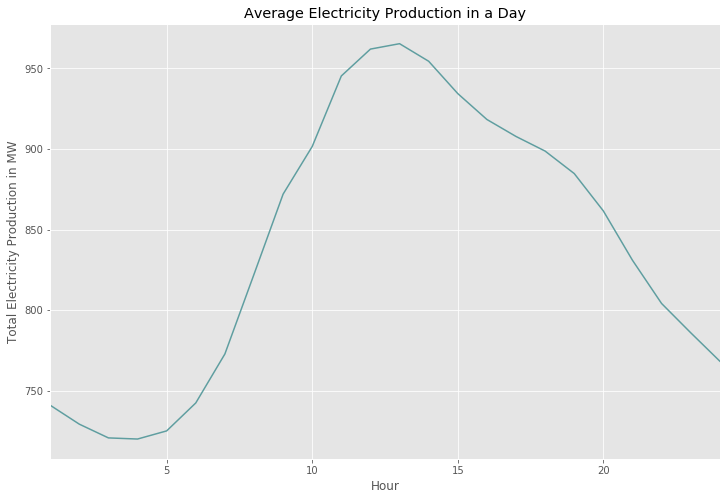

In [16]:
cleaned_data.groupby('hour')['total_prod_mw'].mean().plot(kind='line', color='cadetblue')
plt.title("Average Electricity Production in a Day")
plt.xlabel("Hour")
plt.ylabel("Total Electricity Production in MW")

### To see how on average, carbon footprint due to production changes throughout a day 

In [17]:
carbon_intensity = cleaned_data[['date','weekday','week_number','hour','time_of_day','month','biomass_ci','fossil_gas_ci',
                                 'fossil_hard_coal_ci','fossil_oil_ci','solar_ci','waste_ci','wind_ci','total_ci']].copy()


In [18]:
carbon_intensity #a dataframe created containing carbon intensity of each production type 

,date,weekday,week_number,hour,time_of_day,month,biomass_ci,fossil_gas_ci,fossil_hard_coal_ci,fossil_oil_ci,solar_ci,waste_ci,wind_ci,total_ci
0,2020-01-01 00:00:00,Wednesday,1,1,Night,January,99.36,20.09,162.36,2.60,0.000,50.4,4.114,338.924
1,2020-01-01 00:00:00,Wednesday,1,2,Night,January,105.80,20.09,153.34,2.60,0.000,51.1,3.564,336.494
2,2020-01-01 00:00:00,Wednesday,1,3,Night,January,94.99,16.66,150.88,2.60,0.000,50.4,3.542,319.072
3,2020-01-01 00:00:00,Wednesday,1,4,Night,January,94.53,15.68,147.60,2.60,0.000,51.1,3.883,315.393
4,2020-01-01 00:00:00,Wednesday,1,5,Morning,January,105.34,15.68,150.88,5.20,0.000,49.0,4.301,330.401
5,2020-01-01 00:00:00,Wednesday,1,6,Morning,January,94.07,15.68,152.52,7.80,0.000,44.8,4.906,319.776
6,2020-01-01 00:00:00,Wednesday,1,7,Morning,January,94.30,15.68,151.70,7.80,0.000,44.1,5.467,319.047
7,2020-01-01 00:00:00,Wednesday,1,8,Morning,January,105.80,16.17,154.16,7.80,0.000,44.8,5.654,334.384
8,2020-01-01 00:00:00,Wednesday,1,9,Morning,January,110.17,16.66,153.34,7.80,0.000,44.8,5.038,337.808
9,2020-01-01 00:00:00,Wednesday,1,10,Morning,January,104.88,16.66,135.30,8.45,0.270,45.5,4.906,315.966


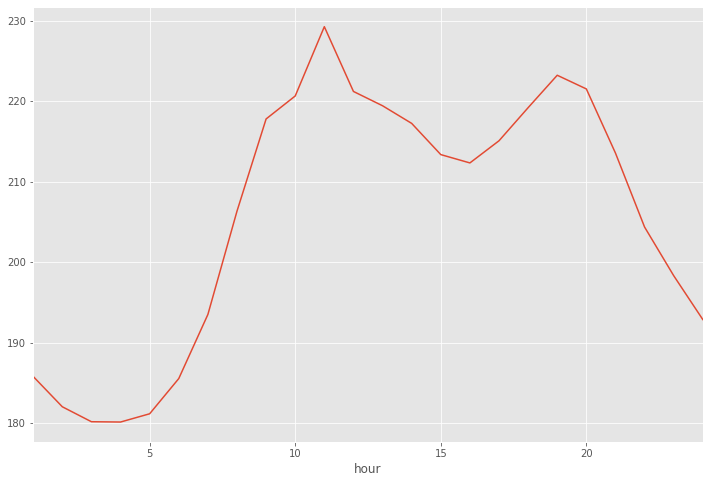

In [22]:
#carbon_intensity.groupby('hour')['biomass_ci','fossil_gas_ci','fossil_hard_coal_ci','fossil_oil_ci','solar_ci','waste_ci','wind_ci'].mean()
carbon_intensity.groupby('hour')['total_ci'].mean().plot(kind='line')

#### To understand the change in total carbon intensity from one day to the next following tasks are performed

In [23]:
total_ci_diff = carbon_intensity['total_ci'].to_list() #total_ci_diff=difference in carbon intensity between two consecutive days

In [24]:
total_ci_diff.insert(0, 0)

In [25]:
len(total_ci_diff)

8786

In [26]:
del total_ci_diff[-1]
len(total_ci_diff)

8785

In [27]:
carbon_intensity['total_ci_diff'] = abs(carbon_intensity['total_ci'] - total_ci_diff)
carbon_intensity

,date,weekday,week_number,hour,time_of_day,month,biomass_ci,fossil_gas_ci,fossil_hard_coal_ci,fossil_oil_ci,solar_ci,waste_ci,wind_ci,total_ci,total_ci_diff
0,2020-01-01 00:00:00,Wednesday,1,1,Night,January,99.36,20.09,162.36,2.60,0.000,50.4,4.114,338.924,338.924
1,2020-01-01 00:00:00,Wednesday,1,2,Night,January,105.80,20.09,153.34,2.60,0.000,51.1,3.564,336.494,2.430
2,2020-01-01 00:00:00,Wednesday,1,3,Night,January,94.99,16.66,150.88,2.60,0.000,50.4,3.542,319.072,17.422
3,2020-01-01 00:00:00,Wednesday,1,4,Night,January,94.53,15.68,147.60,2.60,0.000,51.1,3.883,315.393,3.679
4,2020-01-01 00:00:00,Wednesday,1,5,Morning,January,105.34,15.68,150.88,5.20,0.000,49.0,4.301,330.401,15.008
5,2020-01-01 00:00:00,Wednesday,1,6,Morning,January,94.07,15.68,152.52,7.80,0.000,44.8,4.906,319.776,10.625
6,2020-01-01 00:00:00,Wednesday,1,7,Morning,January,94.30,15.68,151.70,7.80,0.000,44.1,5.467,319.047,0.729
7,2020-01-01 00:00:00,Wednesday,1,8,Morning,January,105.80,16.17,154.16,7.80,0.000,44.8,5.654,334.384,15.337
8,2020-01-01 00:00:00,Wednesday,1,9,Morning,January,110.17,16.66,153.34,7.80,0.000,44.8,5.038,337.808,3.424
9,2020-01-01 00:00:00,Wednesday,1,10,Morning,January,104.88,16.66,135.30,8.45,0.270,45.5,4.906,315.966,21.842


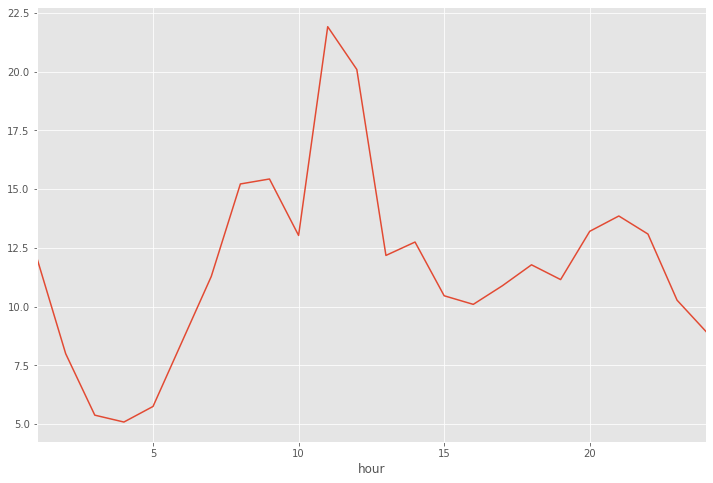

In [29]:
carbon_intensity.groupby('hour')['total_ci_diff'].mean().plot(kind='line')

### To understand how on average, carbon footprint changes based on Time of Day

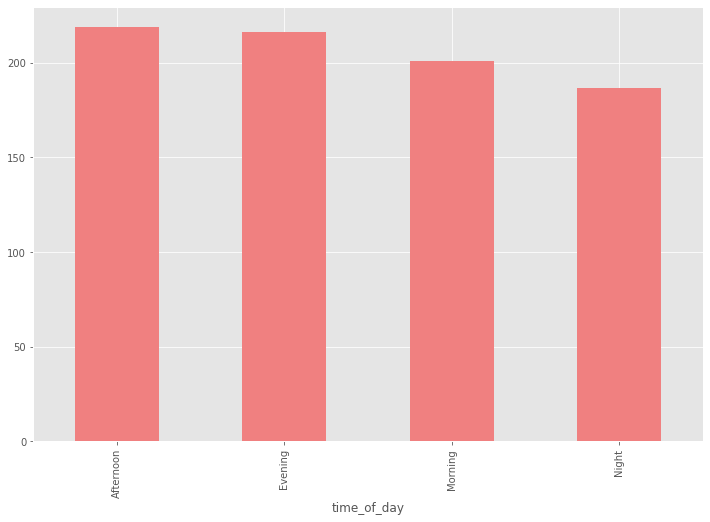

In [32]:
carbon_intensity.groupby('time_of_day')['total_ci'].mean().plot(kind='bar', color=['lightcoral'])

In [39]:
#exporting the dataframe as a csv file to make interactive dashboard of the analysis on Tableau
cleaned_data.to_csv(r'D:\Tanha_datascience\learning\data_analysis\em_project\data\cleaned_data.csv', index = False, header=True)
carbon_intensity.to_csv(r'D:\Tanha_datascience\learning\data_analysis\em_project\data\carbon_intensity.csv', index = False, header=True)

# Analysis to answer the client's following question:
### How can we use your data to help users charge at the greenest times?
To answer this question I am going to fist calculate the percentage of electricity production from green source and non-green source each day. This is because, in general if on a particular day the electricity production is lower, by default the carbon intensity will be lower,but we can't consider that time as the greenest time. The greenest time will be the time when a higher percentage of th overall production comes from the green sources like solar and wind.By calculating the percentage of electricity production from green sources and non-green sources would give us a clear cut answer to which times of the day is the greenest times?

Based on the carbon intensity of each production I have considered the following:
1. Electricity produced via Wind and Solar enerygy are considered greener
2. Electricity produced via Fossil Gas, Fossil Oil, Fossil Hard Coal and Waste enerygy are considered non green
3. Biomass as the neutral point since it's carbon intensity value is 230g/KWh which is neither very nor very low


# Greenest Time of the Day
#### Finding out at which time of the day, the electricity is greenest
- A separate dataframe is created containing production value of each type in MW. 
- Green, Non-Green and Neutral attributes are created based on the carbon intensity of each type.
- Average percentage of Green, Non-Green and Neutral electricity produced each Time of the Day are calculated.
- Results plotted in bar or line graph

In [35]:
time_of_day_prod= cleaned_data.groupby('time_of_day')['biomass','fossil_gas','fossil_hard_coal','fossil_oil','solar','waste','wind_offshore', 'wind_onshore'].mean().reset_index()
time_of_day_prod

,time_of_day,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore
0,Afternoon,212.593807,56.246812,94.396630,19.468579,123.641621,60.774590,143.087432,236.387067
1,Evening,220.162568,53.812386,94.966302,18.771858,31.148907,62.067395,153.280055,230.407104
2,Morning,201.673042,47.215392,91.460383,14.711293,27.033242,59.311020,147.530965,217.036430
3,Night,171.984069,41.644515,88.203004,13.571689,0.618116,59.074647,151.806554,217.274465


In [36]:
time_of_day_prod['green'] = time_of_day_prod['solar'] + time_of_day_prod['wind_offshore'] + time_of_day_prod['wind_onshore']
time_of_day_prod['non_green'] = time_of_day_prod['fossil_gas'] + time_of_day_prod['fossil_hard_coal'] + time_of_day_prod['fossil_oil'] + time_of_day_prod['waste']
time_of_day_prod['neutral'] = time_of_day_prod['biomass'] 
time_of_day_prod

,time_of_day,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral
0,Afternoon,212.593807,56.246812,94.396630,19.468579,123.641621,60.774590,143.087432,236.387067,503.116120,230.886612,212.593807
1,Evening,220.162568,53.812386,94.966302,18.771858,31.148907,62.067395,153.280055,230.407104,414.836066,229.617942,220.162568
2,Morning,201.673042,47.215392,91.460383,14.711293,27.033242,59.311020,147.530965,217.036430,391.600638,212.698087,201.673042
3,Night,171.984069,41.644515,88.203004,13.571689,0.618116,59.074647,151.806554,217.274465,369.699135,202.493855,171.984069


In [37]:
time_of_day_prod['total_prod'] = time_of_day_prod['green'] + time_of_day_prod['non_green'] + time_of_day_prod['neutral']
time_of_day_prod

,time_of_day,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral,total_prod
0,Afternoon,212.593807,56.246812,94.396630,19.468579,123.641621,60.774590,143.087432,236.387067,503.116120,230.886612,212.593807,946.596539
1,Evening,220.162568,53.812386,94.966302,18.771858,31.148907,62.067395,153.280055,230.407104,414.836066,229.617942,220.162568,864.616576
2,Morning,201.673042,47.215392,91.460383,14.711293,27.033242,59.311020,147.530965,217.036430,391.600638,212.698087,201.673042,805.971767
3,Night,171.984069,41.644515,88.203004,13.571689,0.618116,59.074647,151.806554,217.274465,369.699135,202.493855,171.984069,744.177060


In [38]:
time_of_day_prod['green%'] = time_of_day_prod['green'] / time_of_day_prod['total_prod'] * 100
time_of_day_prod['non_green%'] = time_of_day_prod['non_green'] / time_of_day_prod['total_prod'] * 100
time_of_day_prod['neutral%'] = time_of_day_prod['neutral'] / time_of_day_prod['total_prod'] * 100
time_of_day_prod

,time_of_day,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral,total_prod,green%,non_green%,neutral%
0,Afternoon,212.593807,56.246812,94.396630,19.468579,123.641621,60.774590,143.087432,236.387067,503.116120,230.886612,212.593807,946.596539,53.150006,24.391238,22.458756
1,Evening,220.162568,53.812386,94.966302,18.771858,31.148907,62.067395,153.280055,230.407104,414.836066,229.617942,220.162568,864.616576,47.979194,26.557199,25.463607
2,Morning,201.673042,47.215392,91.460383,14.711293,27.033242,59.311020,147.530965,217.036430,391.600638,212.698087,201.673042,805.971767,48.587389,26.390265,25.022346
3,Night,171.984069,41.644515,88.203004,13.571689,0.618116,59.074647,151.806554,217.274465,369.699135,202.493855,171.984069,744.177060,49.678921,27.210440,23.110638


In [39]:
time_of_day_prod.groupby('time_of_day')['green%','non_green%','neutral%'].mean().sort_values(by=['time_of_day'], ascending=True)

,green%,non_green%,neutral%
time_of_day,,,
Afternoon,53.150006,24.391238,22.458756
Evening,47.979194,26.557199,25.463607
Morning,48.587389,26.390265,25.022346
Night,49.678921,27.210440,23.110638


Text(0, 0.5, 'Electricity Production in MW')

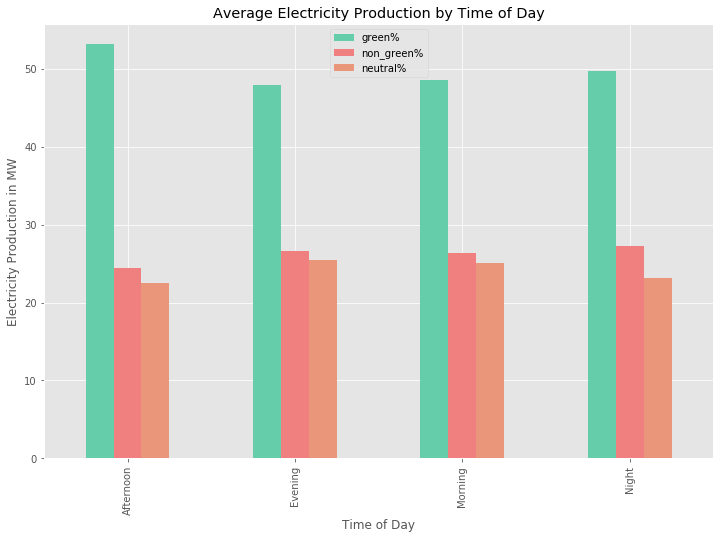

In [40]:
time_of_day_prod.groupby('time_of_day')['green%','non_green%','neutral%'].mean().plot(kind='bar', color=['mediumaquamarine','lightcoral','darksalmon'])
plt.title("Average Electricity Production by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Electricity Production in MW")

Text(0, 0.5, 'Electricity Production in MW')

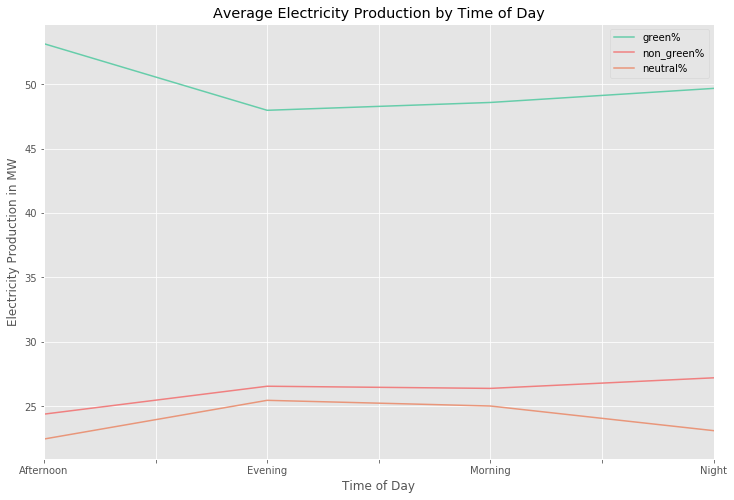

In [41]:
time_of_day_prod.groupby('time_of_day')['green%','non_green%','neutral%'].mean().plot(kind='line', color=['mediumaquamarine','lightcoral','darksalmon'])
plt.title("Average Electricity Production by Time of Day")
plt.xlabel("Time of Day")
plt.ylabel("Electricity Production in MW")

In [42]:
time_of_day_prod.to_csv(r'D:\Tanha_datascience\learning\data_analysis\em_project\data\time_of_day_prod.csv', index = False, header=True)

# Greenest Month
#### Finding out at which month, the electricity is greenest
- A separate dataframe is created containing production value of each type in MW. 
- Green, Non-Green and Neutral attributes are created based on the carbon intensity of each type.
- Average percentage of Green, Non-Green and Neutral electricity produced each month are calculated.
- Results plotted in bar graph

In [43]:
monthly_prod= cleaned_data.groupby('month')['biomass','fossil_gas','fossil_hard_coal','fossil_oil','solar','waste','wind_offshore', 'wind_onshore'].mean().reset_index()
monthly_prod

,month,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore
0,April,177.172222,53.079167,85.745833,18.891667,76.194444,70.211111,128.909722,208.754167
1,August,87.637097,33.452957,48.142473,13.181452,73.904570,48.368280,77.583333,111.983871
2,December,352.548387,99.071237,146.126344,25.717742,3.268817,70.293011,162.705645,205.563172
3,February,383.969828,58.433908,181.915230,19.617816,15.626437,56.479885,265.719828,403.215517
4,January,421.524194,59.947581,159.841398,18.694892,5.869624,58.536290,185.513441,345.498656
5,July,9.985215,22.392473,31.504032,7.106183,64.346774,59.014785,124.430108,196.770161
6,June,117.734722,26.863889,34.031944,13.975000,82.265278,54.875000,111.918056,147.708333
7,March,292.013441,57.954301,175.146505,21.178763,46.010753,61.229839,158.385753,251.255376
8,May,45.403226,46.262097,69.938172,16.456989,82.168011,66.831989,130.262097,198.641129
9,November,263.686111,62.687500,75.322222,19.422222,12.359722,69.176389,189.588889,265.387500


In [44]:
monthly_prod['green'] = monthly_prod['solar'] + monthly_prod['wind_offshore'] + monthly_prod['wind_onshore']
monthly_prod['non_green'] = monthly_prod['fossil_gas'] + monthly_prod['fossil_hard_coal'] + monthly_prod['fossil_oil'] + monthly_prod['waste']
monthly_prod['neutral'] = monthly_prod['biomass'] #considering biomass as the neutral point since it's carbon intensity value is 230g/KWh which is not very green neither non-green
monthly_prod

,month,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral
0,April,177.172222,53.079167,85.745833,18.891667,76.194444,70.211111,128.909722,208.754167,413.858333,227.927778,177.172222
1,August,87.637097,33.452957,48.142473,13.181452,73.904570,48.368280,77.583333,111.983871,263.471774,143.145161,87.637097
2,December,352.548387,99.071237,146.126344,25.717742,3.268817,70.293011,162.705645,205.563172,371.537634,341.208333,352.548387
3,February,383.969828,58.433908,181.915230,19.617816,15.626437,56.479885,265.719828,403.215517,684.561782,316.446839,383.969828
4,January,421.524194,59.947581,159.841398,18.694892,5.869624,58.536290,185.513441,345.498656,536.881720,297.020161,421.524194
5,July,9.985215,22.392473,31.504032,7.106183,64.346774,59.014785,124.430108,196.770161,385.547043,120.017473,9.985215
6,June,117.734722,26.863889,34.031944,13.975000,82.265278,54.875000,111.918056,147.708333,341.891667,129.745833,117.734722
7,March,292.013441,57.954301,175.146505,21.178763,46.010753,61.229839,158.385753,251.255376,455.651882,315.509409,292.013441
8,May,45.403226,46.262097,69.938172,16.456989,82.168011,66.831989,130.262097,198.641129,411.071237,199.489247,45.403226
9,November,263.686111,62.687500,75.322222,19.422222,12.359722,69.176389,189.588889,265.387500,467.336111,226.608333,263.686111


In [45]:
monthly_prod['total_prod'] = monthly_prod['green'] +monthly_prod['non_green'] + monthly_prod['neutral']
monthly_prod

,month,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral,total_prod
0,April,177.172222,53.079167,85.745833,18.891667,76.194444,70.211111,128.909722,208.754167,413.858333,227.927778,177.172222,818.958333
1,August,87.637097,33.452957,48.142473,13.181452,73.904570,48.368280,77.583333,111.983871,263.471774,143.145161,87.637097,494.254032
2,December,352.548387,99.071237,146.126344,25.717742,3.268817,70.293011,162.705645,205.563172,371.537634,341.208333,352.548387,1065.294355
3,February,383.969828,58.433908,181.915230,19.617816,15.626437,56.479885,265.719828,403.215517,684.561782,316.446839,383.969828,1384.978448
4,January,421.524194,59.947581,159.841398,18.694892,5.869624,58.536290,185.513441,345.498656,536.881720,297.020161,421.524194,1255.426075
5,July,9.985215,22.392473,31.504032,7.106183,64.346774,59.014785,124.430108,196.770161,385.547043,120.017473,9.985215,515.549731
6,June,117.734722,26.863889,34.031944,13.975000,82.265278,54.875000,111.918056,147.708333,341.891667,129.745833,117.734722,589.372222
7,March,292.013441,57.954301,175.146505,21.178763,46.010753,61.229839,158.385753,251.255376,455.651882,315.509409,292.013441,1063.174731
8,May,45.403226,46.262097,69.938172,16.456989,82.168011,66.831989,130.262097,198.641129,411.071237,199.489247,45.403226,655.963710
9,November,263.686111,62.687500,75.322222,19.422222,12.359722,69.176389,189.588889,265.387500,467.336111,226.608333,263.686111,957.630556


In [46]:
monthly_prod['green%'] = monthly_prod['green'] / monthly_prod['total_prod'] * 100
monthly_prod['non_green%'] = monthly_prod['non_green'] / monthly_prod['total_prod'] * 100
monthly_prod['neutral%'] = monthly_prod['neutral'] / monthly_prod['total_prod'] * 100
monthly_prod

,month,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral,total_prod,green%,non_green%,neutral%
0,April,177.172222,53.079167,85.745833,18.891667,76.194444,70.211111,128.909722,208.754167,413.858333,227.927778,177.172222,818.958333,50.534724,27.831425,21.633851
1,August,87.637097,33.452957,48.142473,13.181452,73.904570,48.368280,77.583333,111.983871,263.471774,143.145161,87.637097,494.254032,53.306955,28.961860,17.731185
2,December,352.548387,99.071237,146.126344,25.717742,3.268817,70.293011,162.705645,205.563172,371.537634,341.208333,352.548387,1065.294355,34.876523,32.029489,33.093988
3,February,383.969828,58.433908,181.915230,19.617816,15.626437,56.479885,265.719828,403.215517,684.561782,316.446839,383.969828,1384.978448,49.427613,22.848503,27.723885
4,January,421.524194,59.947581,159.841398,18.694892,5.869624,58.536290,185.513441,345.498656,536.881720,297.020161,421.524194,1255.426075,42.764901,23.658913,33.576186
5,July,9.985215,22.392473,31.504032,7.106183,64.346774,59.014785,124.430108,196.770161,385.547043,120.017473,9.985215,515.549731,74.783676,23.279514,1.936809
6,June,117.734722,26.863889,34.031944,13.975000,82.265278,54.875000,111.918056,147.708333,341.891667,129.745833,117.734722,589.372222,58.009464,22.014243,19.976293
7,March,292.013441,57.954301,175.146505,21.178763,46.010753,61.229839,158.385753,251.255376,455.651882,315.509409,292.013441,1063.174731,42.857667,29.676158,27.466176
8,May,45.403226,46.262097,69.938172,16.456989,82.168011,66.831989,130.262097,198.641129,411.071237,199.489247,45.403226,655.963710,62.666765,30.411629,6.921606
9,November,263.686111,62.687500,75.322222,19.422222,12.359722,69.176389,189.588889,265.387500,467.336111,226.608333,263.686111,957.630556,48.801295,23.663440,27.535265


In [47]:
monthly_prod.groupby('month')['green%','non_green%','neutral%'].mean().sort_values(by=['green%','non_green%','neutral%'], ascending=True)

,green%,non_green%,neutral%
month,,,
December,34.876523,32.029489,33.093988
January,42.764901,23.658913,33.576186
March,42.857667,29.676158,27.466176
November,48.801295,23.663440,27.535265
February,49.427613,22.848503,27.723885
April,50.534724,27.831425,21.633851
September,51.200161,25.522211,23.277628
August,53.306955,28.961860,17.731185
June,58.009464,22.014243,19.976293


Text(0, 0.5, 'Electricity Production in MW')

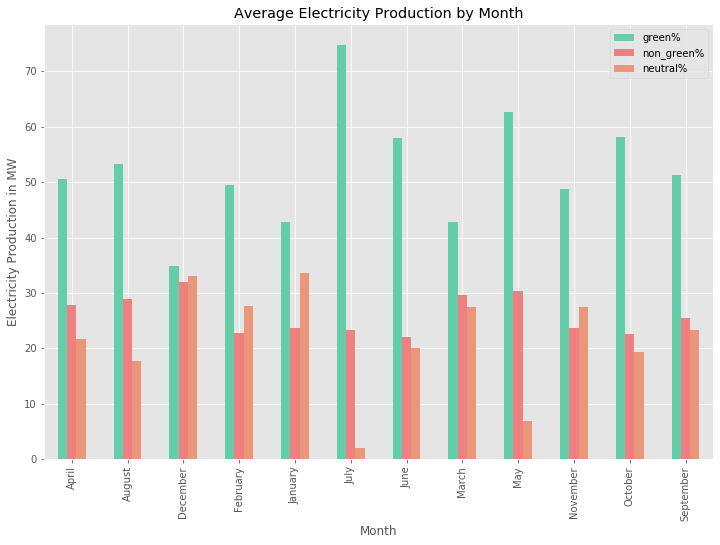

In [48]:
monthly_prod.groupby('month')['green%','non_green%','neutral%'].mean().plot(kind='bar',color=['mediumaquamarine','lightcoral','darksalmon'])
plt.title("Average Electricity Production by Month")
plt.xlabel("Month")
plt.ylabel("Electricity Production in MW")

In [49]:
monthly_prod.to_csv(r'D:\Tanha_datascience\learning\data_analysis\em_project\data\monthly_prod.csv', index = False, header=True)


# Greenest Weekday
#### Finding out at which weekday, the electricity is greenest
- A separate dataframe is created containing production value of each type in MW. 
- Green, Non-Green and Neutral attributes are created based on the carbon intensity of each type.
- Average percentage of Green, Non-Green and Neutral electricity produced each weekday are calculated.
- Results plotted in bar graph

In [50]:
weekly_prod = cleaned_data.groupby('weekday')['biomass','fossil_gas','fossil_hard_coal','fossil_oil','solar','waste','wind_offshore', 'wind_onshore'].mean().reset_index()
weekly_prod

,weekday,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore
0,Friday,219.761218,53.137821,95.295673,16.479167,44.382212,61.273237,128.365385,199.883013
1,Monday,204.531250,53.630609,94.169071,16.845353,48.072917,60.964744,139.592949,206.171474
2,Saturday,170.427885,42.352564,90.155449,14.437500,43.252404,60.185096,144.450321,225.385417
3,Sunday,149.017614,42.345877,88.501201,13.678943,43.551641,57.521217,170.449960,253.303443
4,Thursday,221.030660,53.246069,97.138365,18.889151,45.483491,59.926887,154.647013,231.303459
5,Tuesday,219.779647,52.734776,90.808494,18.472756,48.237179,60.658654,152.016827,227.100962
6,Wednesday,225.853774,50.576258,89.683176,17.551887,46.249214,61.602201,152.762579,233.483491


In [51]:
weekly_prod['green'] = weekly_prod['solar'] + weekly_prod['wind_offshore'] +weekly_prod['wind_onshore']
weekly_prod['non_green'] = weekly_prod['fossil_gas'] + weekly_prod['fossil_hard_coal'] + weekly_prod['fossil_oil'] + weekly_prod['waste']
weekly_prod['neutral'] = weekly_prod['biomass'] #considering biomass as the neutral point since it's carbon intensity value is 230g/KWh which is not very green neither non-green
weekly_prod

,weekday,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral
0,Friday,219.761218,53.137821,95.295673,16.479167,44.382212,61.273237,128.365385,199.883013,372.630609,226.185897,219.761218
1,Monday,204.531250,53.630609,94.169071,16.845353,48.072917,60.964744,139.592949,206.171474,393.837340,225.609776,204.531250
2,Saturday,170.427885,42.352564,90.155449,14.437500,43.252404,60.185096,144.450321,225.385417,413.088141,207.130609,170.427885
3,Sunday,149.017614,42.345877,88.501201,13.678943,43.551641,57.521217,170.449960,253.303443,467.305044,202.047238,149.017614
4,Thursday,221.030660,53.246069,97.138365,18.889151,45.483491,59.926887,154.647013,231.303459,431.433962,229.200472,221.030660
5,Tuesday,219.779647,52.734776,90.808494,18.472756,48.237179,60.658654,152.016827,227.100962,427.354968,222.674679,219.779647
6,Wednesday,225.853774,50.576258,89.683176,17.551887,46.249214,61.602201,152.762579,233.483491,432.495283,219.413522,225.853774


In [52]:
weekly_prod['total_prod'] = weekly_prod['green'] +weekly_prod['non_green'] + weekly_prod['neutral']
weekly_prod

,weekday,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral,total_prod
0,Friday,219.761218,53.137821,95.295673,16.479167,44.382212,61.273237,128.365385,199.883013,372.630609,226.185897,219.761218,818.577724
1,Monday,204.531250,53.630609,94.169071,16.845353,48.072917,60.964744,139.592949,206.171474,393.837340,225.609776,204.531250,823.978365
2,Saturday,170.427885,42.352564,90.155449,14.437500,43.252404,60.185096,144.450321,225.385417,413.088141,207.130609,170.427885,790.646635
3,Sunday,149.017614,42.345877,88.501201,13.678943,43.551641,57.521217,170.449960,253.303443,467.305044,202.047238,149.017614,818.369896
4,Thursday,221.030660,53.246069,97.138365,18.889151,45.483491,59.926887,154.647013,231.303459,431.433962,229.200472,221.030660,881.665094
5,Tuesday,219.779647,52.734776,90.808494,18.472756,48.237179,60.658654,152.016827,227.100962,427.354968,222.674679,219.779647,869.809295
6,Wednesday,225.853774,50.576258,89.683176,17.551887,46.249214,61.602201,152.762579,233.483491,432.495283,219.413522,225.853774,877.762579


In [53]:
weekly_prod['green%'] = weekly_prod['green'] / weekly_prod['total_prod'] * 100
weekly_prod['non_green%'] = weekly_prod['non_green'] / weekly_prod['total_prod'] * 100
weekly_prod['neutral%'] = weekly_prod['neutral'] / weekly_prod['total_prod'] * 100
weekly_prod

,weekday,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral,total_prod,green%,non_green%,neutral%
0,Friday,219.761218,53.137821,95.295673,16.479167,44.382212,61.273237,128.365385,199.883013,372.630609,226.185897,219.761218,818.577724,45.521714,27.631573,26.846714
1,Monday,204.531250,53.630609,94.169071,16.845353,48.072917,60.964744,139.592949,206.171474,393.837340,225.609776,204.531250,823.978365,47.797049,27.380546,24.822405
2,Saturday,170.427885,42.352564,90.155449,14.437500,43.252404,60.185096,144.450321,225.385417,413.088141,207.130609,170.427885,790.646635,52.246873,26.197621,21.555506
3,Sunday,149.017614,42.345877,88.501201,13.678943,43.551641,57.521217,170.449960,253.303443,467.305044,202.047238,149.017614,818.369896,57.101935,24.688987,18.209078
4,Thursday,221.030660,53.246069,97.138365,18.889151,45.483491,59.926887,154.647013,231.303459,431.433962,229.200472,221.030660,881.665094,48.933996,25.996319,25.069685
5,Tuesday,219.779647,52.734776,90.808494,18.472756,48.237179,60.658654,152.016827,227.100962,427.354968,222.674679,219.779647,869.809295,49.132030,25.600402,25.267567
6,Wednesday,225.853774,50.576258,89.683176,17.551887,46.249214,61.602201,152.762579,233.483491,432.495283,219.413522,225.853774,877.762579,49.272468,24.996910,25.730622


In [54]:
weekly_prod.groupby('weekday')['green%','non_green%','neutral%'].mean().sort_values(by=['green%','non_green%','neutral%'], ascending=True)

,green%,non_green%,neutral%
weekday,,,
Friday,45.521714,27.631573,26.846714
Monday,47.797049,27.380546,24.822405
Thursday,48.933996,25.996319,25.069685
Tuesday,49.132030,25.600402,25.267567
Wednesday,49.272468,24.996910,25.730622
Saturday,52.246873,26.197621,21.555506
Sunday,57.101935,24.688987,18.209078


Text(0, 0.5, 'Electricity Production in MW')

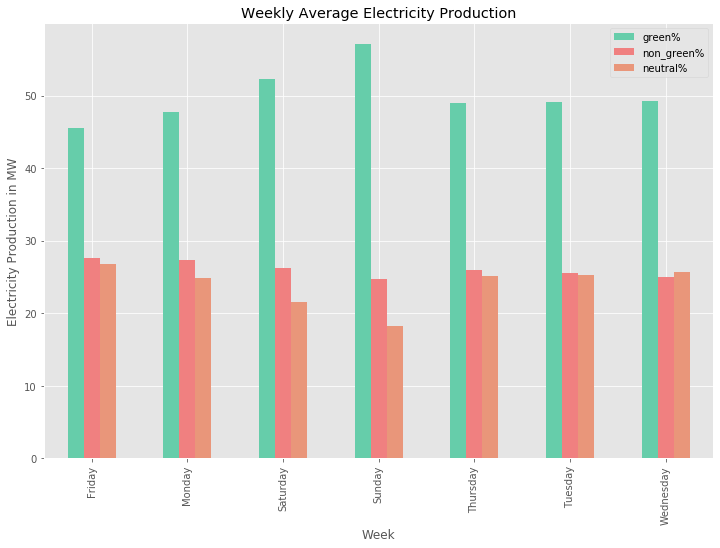

In [55]:
weekly_prod.groupby('weekday')['green%','non_green%','neutral%'].mean().plot(kind='bar',color=['mediumaquamarine','lightcoral','darksalmon'])
plt.title("Weekly Average Electricity Production")
plt.xlabel("Week")
plt.ylabel("Electricity Production in MW")

In [56]:
weekly_prod.to_csv(r'D:\Tanha_datascience\learning\data_analysis\em_project\data\weekly_prod.csv', index = False, header=True)


# Greenest Time of Day vs Weekday

In [58]:
time_week_prod= cleaned_data.groupby(['weekday','time_of_day'])['biomass','fossil_gas','fossil_hard_coal','fossil_oil','solar','waste','wind_offshore', 'wind_onshore'].mean().reset_index()
time_week_prod

,weekday,time_of_day,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore
0,Friday,Afternoon,226.913462,62.419872,97.153846,18.099359,120.794872,62.179487,121.564103,201.801282
1,Friday,Evening,225.746795,56.496795,97.163462,18.647436,30.455128,63.939103,135.621795,205.852564
2,Friday,Morning,233.625000,50.958333,95.038462,15.394231,25.868590,59.599359,124.692308,190.092949
3,Friday,Night,192.759615,42.676282,91.826923,13.775641,0.410256,59.375000,131.583333,201.785256
4,Monday,Afternoon,216.980769,62.560897,94.974359,19.355769,131.134615,61.868590,123.262821,207.820513
5,Monday,Evening,238.666667,60.955128,96.615385,19.865385,34.057692,62.144231,141.019231,203.721154
6,Monday,Morning,204.400641,50.192308,95.721154,14.576923,27.099359,60.548077,142.740385,203.000000
7,Monday,Night,158.076923,40.814103,89.365385,13.583333,0.000000,59.298077,151.349359,210.144231
8,Saturday,Afternoon,171.964744,43.038462,90.137821,15.163462,118.394231,60.352564,136.881410,236.128205
9,Saturday,Evening,175.942308,44.750000,92.926282,15.903846,28.657051,61.153846,155.516026,256.538462


In [59]:
time_week_prod['green'] = (time_week_prod['solar'] + time_week_prod['wind_offshore'] + time_week_prod['wind_onshore'])
time_week_prod['non_green'] = time_week_prod['fossil_gas'] + time_week_prod['fossil_hard_coal'] + time_week_prod['fossil_oil'] + time_week_prod['waste']
time_week_prod['neutral'] = time_week_prod['biomass'] 
time_week_prod

,weekday,time_of_day,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral
0,Friday,Afternoon,226.913462,62.419872,97.153846,18.099359,120.794872,62.179487,121.564103,201.801282,444.160256,239.852564,226.913462
1,Friday,Evening,225.746795,56.496795,97.163462,18.647436,30.455128,63.939103,135.621795,205.852564,371.929487,236.246795,225.746795
2,Friday,Morning,233.625000,50.958333,95.038462,15.394231,25.868590,59.599359,124.692308,190.092949,340.653846,220.990385,233.625000
3,Friday,Night,192.759615,42.676282,91.826923,13.775641,0.410256,59.375000,131.583333,201.785256,333.778846,207.653846,192.759615
4,Monday,Afternoon,216.980769,62.560897,94.974359,19.355769,131.134615,61.868590,123.262821,207.820513,462.217949,238.759615,216.980769
5,Monday,Evening,238.666667,60.955128,96.615385,19.865385,34.057692,62.144231,141.019231,203.721154,378.798077,239.580128,238.666667
6,Monday,Morning,204.400641,50.192308,95.721154,14.576923,27.099359,60.548077,142.740385,203.000000,372.839744,221.038462,204.400641
7,Monday,Night,158.076923,40.814103,89.365385,13.583333,0.000000,59.298077,151.349359,210.144231,361.493590,203.060897,158.076923
8,Saturday,Afternoon,171.964744,43.038462,90.137821,15.163462,118.394231,60.352564,136.881410,236.128205,491.403846,208.692308,171.964744
9,Saturday,Evening,175.942308,44.750000,92.926282,15.903846,28.657051,61.153846,155.516026,256.538462,440.711538,214.733974,175.942308


In [60]:
time_week_prod['total_prod'] = time_week_prod['green'] +time_week_prod['non_green'] + time_week_prod['neutral']
time_week_prod

,weekday,time_of_day,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral,total_prod
0,Friday,Afternoon,226.913462,62.419872,97.153846,18.099359,120.794872,62.179487,121.564103,201.801282,444.160256,239.852564,226.913462,910.926282
1,Friday,Evening,225.746795,56.496795,97.163462,18.647436,30.455128,63.939103,135.621795,205.852564,371.929487,236.246795,225.746795,833.923077
2,Friday,Morning,233.625000,50.958333,95.038462,15.394231,25.868590,59.599359,124.692308,190.092949,340.653846,220.990385,233.625000,795.269231
3,Friday,Night,192.759615,42.676282,91.826923,13.775641,0.410256,59.375000,131.583333,201.785256,333.778846,207.653846,192.759615,734.192308
4,Monday,Afternoon,216.980769,62.560897,94.974359,19.355769,131.134615,61.868590,123.262821,207.820513,462.217949,238.759615,216.980769,917.958333
5,Monday,Evening,238.666667,60.955128,96.615385,19.865385,34.057692,62.144231,141.019231,203.721154,378.798077,239.580128,238.666667,857.044872
6,Monday,Morning,204.400641,50.192308,95.721154,14.576923,27.099359,60.548077,142.740385,203.000000,372.839744,221.038462,204.400641,798.278846
7,Monday,Night,158.076923,40.814103,89.365385,13.583333,0.000000,59.298077,151.349359,210.144231,361.493590,203.060897,158.076923,722.631410
8,Saturday,Afternoon,171.964744,43.038462,90.137821,15.163462,118.394231,60.352564,136.881410,236.128205,491.403846,208.692308,171.964744,872.060897
9,Saturday,Evening,175.942308,44.750000,92.926282,15.903846,28.657051,61.153846,155.516026,256.538462,440.711538,214.733974,175.942308,831.387821


In [61]:
time_week_prod['green%'] = time_week_prod['green'] / time_week_prod['total_prod'] * 100
time_week_prod['non_green%'] = time_week_prod['non_green'] / time_week_prod['total_prod'] * 100
time_week_prod['neutral%'] = time_week_prod['neutral'] / time_week_prod['total_prod'] * 100
time_week_prod

,weekday,time_of_day,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral,total_prod,green%,non_green%,neutral%
0,Friday,Afternoon,226.913462,62.419872,97.153846,18.099359,120.794872,62.179487,121.564103,201.801282,444.160256,239.852564,226.913462,910.926282,48.759188,26.330623,24.910189
1,Friday,Evening,225.746795,56.496795,97.163462,18.647436,30.455128,63.939103,135.621795,205.852564,371.929487,236.246795,225.746795,833.923077,44.599975,28.329567,27.070458
2,Friday,Morning,233.625000,50.958333,95.038462,15.394231,25.868590,59.599359,124.692308,190.092949,340.653846,220.990385,233.625000,795.269231,42.835034,27.788122,29.376844
3,Friday,Night,192.759615,42.676282,91.826923,13.775641,0.410256,59.375000,131.583333,201.785256,333.778846,207.653846,192.759615,734.192308,45.462046,28.283305,26.254649
4,Monday,Afternoon,216.980769,62.560897,94.974359,19.355769,131.134615,61.868590,123.262821,207.820513,462.217949,238.759615,216.980769,917.958333,50.352825,26.009853,23.637322
5,Monday,Evening,238.666667,60.955128,96.615385,19.865385,34.057692,62.144231,141.019231,203.721154,378.798077,239.580128,238.666667,857.044872,44.198162,27.954211,27.847628
6,Monday,Morning,204.400641,50.192308,95.721154,14.576923,27.099359,60.548077,142.740385,203.000000,372.839744,221.038462,204.400641,798.278846,46.705452,27.689380,25.605168
7,Monday,Night,158.076923,40.814103,89.365385,13.583333,0.000000,59.298077,151.349359,210.144231,361.493590,203.060897,158.076923,722.631410,50.024616,28.100204,21.875180
8,Saturday,Afternoon,171.964744,43.038462,90.137821,15.163462,118.394231,60.352564,136.881410,236.128205,491.403846,208.692308,171.964744,872.060897,56.349717,23.930933,19.719350
9,Saturday,Evening,175.942308,44.750000,92.926282,15.903846,28.657051,61.153846,155.516026,256.538462,440.711538,214.733974,175.942308,831.387821,53.009141,25.828376,21.162483


In [62]:
time_week_prod.groupby(['weekday','time_of_day'])['green%','non_green%','neutral%'].mean().sort_values(by=['green%','non_green%','neutral%'], ascending=True)

,,green%,non_green%,neutral%
weekday,time_of_day,,,
Friday,Morning,42.835034,27.788122,29.376844
Monday,Evening,44.198162,27.954211,27.847628
Friday,Evening,44.599975,28.329567,27.070458
Thursday,Evening,45.062481,27.153958,27.783561
Friday,Night,45.462046,28.283305,26.254649
Monday,Morning,46.705452,27.689380,25.605168
Tuesday,Morning,46.895791,26.173533,26.930676
Wednesday,Evening,47.140562,25.457995,27.401443
Tuesday,Evening,47.401525,25.881581,26.716894


Text(0, 0.5, 'Electricity Production in MW')

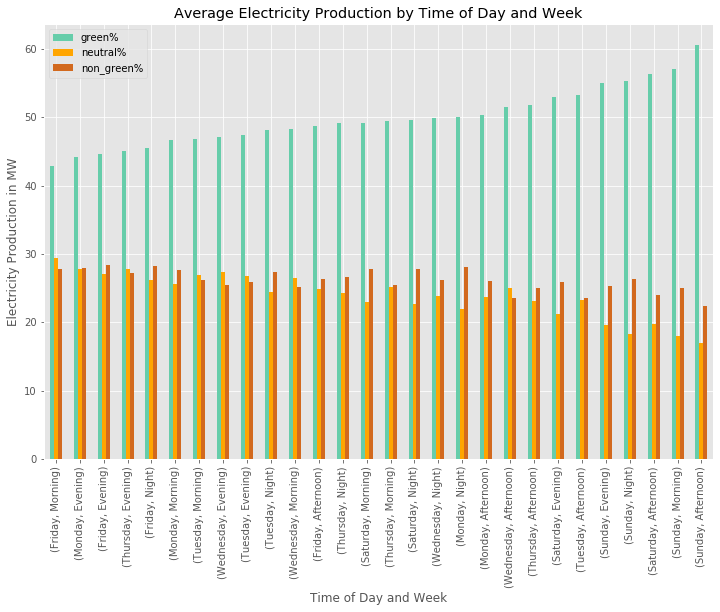

In [63]:
time_week_prod.groupby(['weekday','time_of_day'])['green%','neutral%','non_green%'].mean().sort_values(by=['green%','neutral%','non_green%'], ascending=True).plot(kind='bar',color=['mediumaquamarine','orange','chocolate'])
plt.title("Average Electricity Production by Time of Day and Week")
plt.xlabel("Time of Day and Week")
plt.ylabel("Electricity Production in MW")

# Greenest Hour
#### Finding out at which hour, the electricity is greenest
- A separate dataframe is created containing production value of each type in MW. 
- Green, Non-Green and Neutral attributes are created based on the carbon intensity of each type.
- Average percentage of Green, Non-Green and Neutral electricity produced each hour are calculated.
- Results plotted in bar graph

In [65]:
hour_prod= cleaned_data.groupby('hour')['biomass','fossil_gas','fossil_hard_coal','fossil_oil','solar','waste','wind_offshore', 'wind_onshore'].mean().reset_index()
hour_prod

,hour,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore
0,1,170.923497,41.420765,88.300546,13.631148,0.590164,58.355191,149.775956,217.964481
1,2,163.983607,40.912568,87.043716,12.825137,0.590164,57.860656,150.259563,215.740437
2,3,160.438692,40.446866,86.242507,12.689373,0.713896,57.811989,148.956403,213.389646
3,4,160.997268,40.166667,86.005464,12.923497,0.590164,57.852459,148.393443,213.060109
4,5,166.158470,40.051913,85.983607,12.751366,0.590164,57.885246,148.524590,213.090164
5,6,178.076503,40.330601,87.128415,12.724044,1.737705,58.598361,147.926230,215.852459
6,7,197.054645,40.975410,89.734973,13.021858,7.942623,59.543716,147.407104,217.081967
7,8,216.893443,48.000000,93.330601,14.565574,22.838798,59.808743,148.587432,218.163934
8,9,227.122951,56.035519,96.226776,16.737705,50.188525,60.035519,148.243169,217.366120
9,10,224.732240,57.898907,96.357923,18.467213,78.901639,59.994536,144.497268,220.663934


In [66]:
hour_prod['green'] = (hour_prod['solar'] + hour_prod['wind_offshore'] + hour_prod['wind_onshore'])
hour_prod['non_green'] = hour_prod['fossil_gas'] + hour_prod['fossil_hard_coal'] + hour_prod['fossil_oil'] + hour_prod['waste']
hour_prod['neutral'] = hour_prod['biomass'] 
hour_prod

,hour,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral
0,1,170.923497,41.420765,88.300546,13.631148,0.590164,58.355191,149.775956,217.964481,368.330601,201.707650,170.923497
1,2,163.983607,40.912568,87.043716,12.825137,0.590164,57.860656,150.259563,215.740437,366.590164,198.642077,163.983607
2,3,160.438692,40.446866,86.242507,12.689373,0.713896,57.811989,148.956403,213.389646,363.059946,197.190736,160.438692
3,4,160.997268,40.166667,86.005464,12.923497,0.590164,57.852459,148.393443,213.060109,362.043716,196.948087,160.997268
4,5,166.158470,40.051913,85.983607,12.751366,0.590164,57.885246,148.524590,213.090164,362.204918,196.672131,166.158470
5,6,178.076503,40.330601,87.128415,12.724044,1.737705,58.598361,147.926230,215.852459,365.516393,198.781421,178.076503
6,7,197.054645,40.975410,89.734973,13.021858,7.942623,59.543716,147.407104,217.081967,372.431694,203.275956,197.054645
7,8,216.893443,48.000000,93.330601,14.565574,22.838798,59.808743,148.587432,218.163934,389.590164,215.704918,216.893443
8,9,227.122951,56.035519,96.226776,16.737705,50.188525,60.035519,148.243169,217.366120,415.797814,229.035519,227.122951
9,10,224.732240,57.898907,96.357923,18.467213,78.901639,59.994536,144.497268,220.663934,444.062842,232.718579,224.732240


In [67]:
hour_prod['total_prod'] = hour_prod['green'] +hour_prod['non_green'] + hour_prod['neutral']
hour_prod

,hour,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral,total_prod
0,1,170.923497,41.420765,88.300546,13.631148,0.590164,58.355191,149.775956,217.964481,368.330601,201.707650,170.923497,740.961749
1,2,163.983607,40.912568,87.043716,12.825137,0.590164,57.860656,150.259563,215.740437,366.590164,198.642077,163.983607,729.215847
2,3,160.438692,40.446866,86.242507,12.689373,0.713896,57.811989,148.956403,213.389646,363.059946,197.190736,160.438692,720.689373
3,4,160.997268,40.166667,86.005464,12.923497,0.590164,57.852459,148.393443,213.060109,362.043716,196.948087,160.997268,719.989071
4,5,166.158470,40.051913,85.983607,12.751366,0.590164,57.885246,148.524590,213.090164,362.204918,196.672131,166.158470,725.035519
5,6,178.076503,40.330601,87.128415,12.724044,1.737705,58.598361,147.926230,215.852459,365.516393,198.781421,178.076503,742.374317
6,7,197.054645,40.975410,89.734973,13.021858,7.942623,59.543716,147.407104,217.081967,372.431694,203.275956,197.054645,772.762295
7,8,216.893443,48.000000,93.330601,14.565574,22.838798,59.808743,148.587432,218.163934,389.590164,215.704918,216.893443,822.188525
8,9,227.122951,56.035519,96.226776,16.737705,50.188525,60.035519,148.243169,217.366120,415.797814,229.035519,227.122951,871.956284
9,10,224.732240,57.898907,96.357923,18.467213,78.901639,59.994536,144.497268,220.663934,444.062842,232.718579,224.732240,901.513661


In [68]:
hour_prod['green%'] = hour_prod['green'] / hour_prod['total_prod'] * 100
hour_prod['non_green%'] = hour_prod['non_green'] / hour_prod['total_prod'] * 100
hour_prod['neutral%'] = hour_prod['neutral'] / hour_prod['total_prod'] * 100
hour_prod

,hour,biomass,fossil_gas,fossil_hard_coal,fossil_oil,solar,waste,wind_offshore,wind_onshore,green,non_green,neutral,total_prod,green%,non_green%,neutral%
0,1,170.923497,41.420765,88.300546,13.631148,0.590164,58.355191,149.775956,217.964481,368.330601,201.707650,170.923497,740.961749,49.709800,27.222411,23.067790
1,2,163.983607,40.912568,87.043716,12.825137,0.590164,57.860656,150.259563,215.740437,366.590164,198.642077,163.983607,729.215847,50.271832,27.240505,22.487664
2,3,160.438692,40.446866,86.242507,12.689373,0.713896,57.811989,148.956403,213.389646,363.059946,197.190736,160.438692,720.689373,50.376759,27.361405,22.261837
3,4,160.997268,40.166667,86.005464,12.923497,0.590164,57.852459,148.393443,213.060109,362.043716,196.948087,160.997268,719.989071,50.284613,27.354316,22.361071
4,5,166.158470,40.051913,85.983607,12.751366,0.590164,57.885246,148.524590,213.090164,362.204918,196.672131,166.158470,725.035519,49.956852,27.125862,22.917287
5,6,178.076503,40.330601,87.128415,12.724044,1.737705,58.598361,147.926230,215.852459,365.516393,198.781421,178.076503,742.374317,49.236131,26.776441,23.987428
6,7,197.054645,40.975410,89.734973,13.021858,7.942623,59.543716,147.407104,217.081967,372.431694,203.275956,197.054645,772.762295,48.194858,26.305108,25.500034
7,8,216.893443,48.000000,93.330601,14.565574,22.838798,59.808743,148.587432,218.163934,389.590164,215.704918,216.893443,822.188525,47.384529,26.235457,26.380013
8,9,227.122951,56.035519,96.226776,16.737705,50.188525,60.035519,148.243169,217.366120,415.797814,229.035519,227.122951,871.956284,47.685626,26.266858,26.047516
9,10,224.732240,57.898907,96.357923,18.467213,78.901639,59.994536,144.497268,220.663934,444.062842,232.718579,224.732240,901.513661,49.257472,25.814204,24.928323


In [75]:
hour_prod.groupby('hour')['green%','non_green%','neutral%'].mean().sort_values(by=['green%','non_green%','neutral%'], ascending= False)

,green%,non_green%,neutral%
hour,,,
15,54.182689,24.251613,21.565697
14,54.163899,24.061011,21.775089
13,53.769427,23.830536,22.400036
16,53.178910,24.494927,22.326163
12,52.872525,24.052125,23.075350
17,51.357632,25.043268,23.599101
11,50.727365,25.679601,23.593034
3,50.376759,27.361405,22.261837
4,50.284613,27.354316,22.361071


Text(0, 0.5, 'Percentage of Green, Non-green, Neutral')

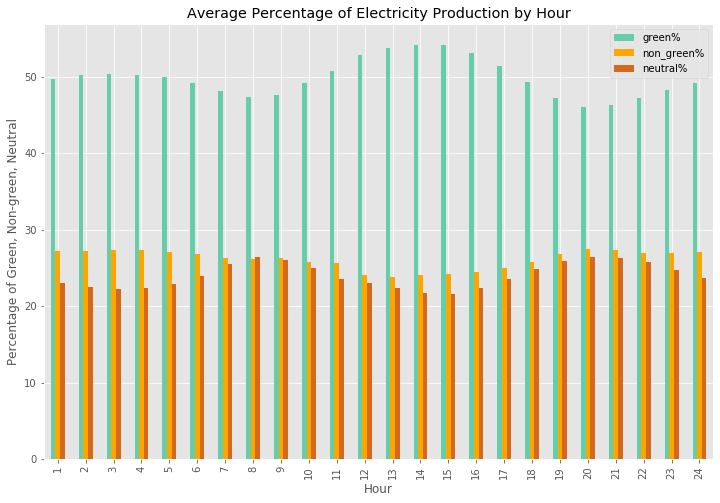

In [77]:
hour_prod.groupby('hour')['green%','non_green%','neutral%'].mean().plot(kind='bar',color=['mediumaquamarine','orange','chocolate'])
plt.title("Average Percentage of Electricity Production by Hour")
plt.xlabel("Hour")
plt.ylabel("Percentage of Green, Non-green, Neutral")

In [78]:
hour_prod.to_csv(r'D:\Tanha_datascience\learning\data_analysis\em_project\data\hour_prod.csv', index = False, header=True)
#dataframe exported as csv file for building Tableau dashboard

In [79]:
conn.close()

### Refer to the pdf named "Analysis Report for Client" for indepth explanation of my analysis